# 因果フォレスト（Causal Forests）をPythonで実践的に学ぶ（その５） 因果フォレストのチューニングと最適化（後半）

url: https://www.salesanalytics.co.jp/datascience/datascience189/

    因果推論は、ビジネスや研究の多くの分野での意思決定を支える重要な手法となっています。

    特に因果フォレストは、複雑なデータ構造の中から因果関係を明らかにするのに非常に効果的です。

    ただ、適切なモデルを構築するためには、ハイパーパラメータがある場合には、そのチューニングによる最適化が欠かせません。

    今まで、PythonのEconMLライブラリを用いて紹介してきました

    このEconMLのCausalForestDMLには、3種類のハイパーパラメータが登場します。

    ・因果フォレストそのものののハイパーパラメータ
    ・アウトカムモデルのハイパーパラメータ
    ・トリートメントモデルのハイパーパラメータ

    前回は、因果フォレストそのもののハイパーパラメータをチューニングし最適化する方法について説明しました。

    url: https://www.salesanalytics.co.jp/datascience/datascience188/

    今回は、トリートメントモデルとアウトカムモデルのハイパーパラメータのチューニングも組み込んだ、因果フォレスト全体のハイパーパラメータをチューニングし最適化する方法について説明します。

    要するに、前回の続きになりますので、前回の記事をまだ読まれていない方は、前回の記事を一読しておくことをお勧めします。

## 2つの方略
    2つの方略があります。
    ・一度にハイパーパラメータチューニング
    ・個別にハイパーパラメータチューニング

## 一度にハイパーパラメータチューニング
    「一度にハイパーパラメータチューニング」とは、以下の3種類のハイパーパラメータを、一度に実施するという王道なやり方です。
    ・因果フォレストそのものののハイパーパラメータ
    ・アウトカムモデルのハイパーパラメータ
    ・トリートメントモデルのハイパーパラメータ

    ただし、非常に時間がかかることが予想されます。

## 個別にハイパーパラメータチューニング
    「個別にハイパーパラメータチューニング」とは、先程の3種類のハイパーパラメータを、順番にハイパーパラメータチューニングするということです。

    例えば、次のようになります。
    ・アウトカムモデルとトリートメントモデルのハイパーパラメータをチューニング
    ・因果フォレストそのものののハイパーパラメータのハイパーパラメータをチューニング
    
    先ず、以下の2種類のハイパーパラメータをチューニングします。
    ・アウトカムモデルのハイパーパラメータ
    ・トリートメントモデルのハイパーパラメータ

    このチューニングで、トリートメントモデルとアウトカムモデルのハイパーパラメータを手にできます。

    次に、このハイパーパラメータを固定し、以下の残りのハイパーパラメータをチューニングします。

    ・因果フォレストそのものののハイパーパラメータ

    一度にハイパーパラメータをチューニングするより、計算時間が短くなります。ちょっとではなく、かなり短くなります。

## サンプルデータで実施
    以下の2つのサンプルデータを使います。
    不動産業: cf_sampledata_1.csv (https://www.salesanalytics.co.jp/yehi)
    製薬業: cf_sampledata_2.csv (https://www.salesanalytics.co.jp/xnlp)
    
    それぞれのサンプルデータで、3種類の因果フォレストを構築し、因果効果をプロットします。

    ・ハイパーパラメータチューニングしない
    ・一度にパイパーパラメータチューニングする
    ・個別にパイパーパラメータチューニングする
    
    今回は、単に因果効果をプロットするだけでなく、その信頼区間も一緒にグラフに表示します。



##共通して利用するモジュール
    共通して利用するモジュールを読み込みます。

    以下、コードです。

In [1]:
pip install econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 46.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold

from econml.dml import CausalForestDML

from statsmodels.nonparametric.kernel_regression import KernelReg

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

    numpy as np: NumPy（Numerical Python）は、Pythonで数値計算を効率的に行うためのライブラリです。多次元配列のサポートや線形代数の操作などが可能です。
    pandas as pd: Pandasは、データ解析とデータ操作のための高度なデータ構造（DataFrameなど）とメソッドを提供するPythonライブラリです。

    scikit-learn（sklearn）のモジュールなど
    ・RandomForestRegressor: scikit-learn（sklearn）のensembleモジュールからRandomForestRegressorをインポートしています。これはランダムフォレストを用いた回帰問題の解法に使われます。
    ・RandomForestClassifier: RandomForestClassifierも同じくランダムフォレストを使いますが、こちらは分類問題に用いられます。
    ・GridSearchCV: グリッドサーチと交差検証（Cross-Validation）を組み合わせて、ハイパーパラメータの最適な組み合わせを探します。
    ・ParameterGrid: ハイパーパラメータの全ての組み合わせを生成するためのユーティリティです。
    ・KFold: K-Fold交差検証を行うためのクラスです。データセットをK個のサブセット（”fold”）に分割し、交差検証を行います。
    
    ・CausalForestDML: EconMLライブラリのdml（Double Machine Learning）モジュールからCausalForestDMLをインポートしています。これは因果推論（Causal Inference）のための機械学習モデルです。
    ・KernelReg: Statsmodelsライブラリのnonparametric.kernel_regressionモジュールからKernelRegをインポートしています。これは非線形回帰のためのカーネル回帰モデルです。
    ・matplotlib.pyplot as plt: Matplotlibのpyplotモジュールは、プロットや可視化を行うためのインターフェースです。
    ・plt.style.use(‘ggplot’): ggplotスタイルをMatplotlibのプロットに適用しています。これはR言語のggplot2パッケージに似たビジュアルスタイルです。
    ・plt.rcParams[‘figure.figsize’] = [12, 9]: プロットのデフォルトのサイズを12×9インチに設定しています。

## ハイパーパラメータチューニング関数の生成
    PythonのEconMLライブラリに、因果フォレストそのもののハイパーパラメータをチューニングする機能が、現在（2023年8月23日現在）実装されていないので、そのための関数を作ります。

    以下、コードです。

In [3]:
def cs_grid_search(Y, T, X, W, estimator_class, param_grid, cv=10):
    # パラメータの組み合わせを全て生成する
    grid = ParameterGrid(param_grid)

    # K-fold交差検証のための分割器を生成
    kf = KFold(n_splits=cv)

    # 最適なスコアとそのときのパラメータを初期化
    best_score = float('inf')
    best_params = None

    # すべてのパラメータの組み合わせに対してループ
    for params in grid:
        # エスティメータのインスタンスを生成
        estimator = estimator_class(**params)
        scores = []

        # 学習データと検証データのインデックスを取得するループ
        for train_idx, test_idx in kf.split(X):
            # 学習データと検証データに分割
            X_train, X_test = X[train_idx], X[test_idx]
            Y_train, Y_test = Y[train_idx], Y[test_idx]
            T_train, T_test = T[train_idx], T[test_idx]
            W_train, W_test = W[train_idx], W[test_idx]

            # モデルを学習
            estimator.fit(Y_train, T_train, X=X_train, W=W_train)
            # 検証データでのスコアを計算
            score = estimator.score(Y_test, T_test, X_test, W_test)
            scores.append(score)

        # 平均スコアを計算
        avg_score = sum(scores) / cv
        # 今までの最適なスコアよりも良ければ、更新する
        if avg_score < best_score:
            best_score = avg_score
            best_params = params
            best_model = estimator

    # 最適なモデル、その時のパラメータ、そしてスコアを返す
    return best_model, best_params, best_score

    この関数cs_grid_searchの説明は以下の通りです。

    入力:
    ・Y: アウトカム（目的変数）
    ・T: トリートメント（介入変数）
    ・X: 特徴量
    ・W: 制御変数
    ・estimator_class: グリッドサーチを行いたいエスティメータ（推定器）のクラス
    ・param_grid: 探索するパラメータの組み合わせの辞書
    ・cv: クロスバリデーション（交差検証）の分割数（デフォルトは10）

1. ParameterGridを使用して、提供されたparam_gridから全てのパラメータの組み合わせを生成します。
2. KFoldを使用して、データをcv回のクロスバリデーション（交差検証）用に分割します。
3. すべてのパラメータの組み合わせに対して、モデルを学習し、テストデータでのスコアを計算します。
4. 各パラメータの組み合わせにおける平均スコアを計算し、これまでの最良のスコアよりも良ければ、スコアとパラメータを更新します。
5. 最も良いスコアを持つモデル、そのときのパラメータ、およびスコアを返します。


## データセットの読み込みと設定
    では、データセットを読み込みます。

    以下、コードです。

In [4]:
# データセットのロード
df = pd.read_csv("https://www.salesanalytics.co.jp/yehi")

display(df) #確認

,House_Price,Is_Park_Opened,Distance_to_Park,House_Area,Year_Built,Average_Income
0,360290.080492,1,2.744068,105.017033,2008,40149.842780
1,385180.305950,0,3.575947,94.643627,2020,24032.202540
2,329468.964585,1,3.013817,60.289939,2008,21737.611179
3,378124.682277,0,2.724416,102.879130,1981,73571.036967
4,359181.496039,0,2.118274,84.829407,1982,99219.893824
...,...,...,...,...,...,...
4995,340872.676505,0,1.090779,132.567023,2007,48753.051134
4996,390448.842140,1,1.177267,109.572700,2015,84686.048189
4997,407786.862894,1,0.986941,163.764428,1992,45547.429229
4998,393211.462527,0,1.993436,53.568114,1986,72746.100909


    House_Price: 家の価格を示す数値です。Yです。
    Is_Park_Opened: 公園が開かれているかどうかを示すバイナリ変数です（0 = 開かれていない, 1 = 開かれている）。Tです。
    Distance_to_Park: 家から公園までの距離を示す数値です。Xです。
    House_Area: 家の面積を示す数値です。Wです。
    Year_Built: 家が建てられた年を示す数値です。Wです。
    Average_Income: 地域の平均所得を示す数値です。Wです。

    Y,T,X,Wを設定していきます。

    以下、コードです。

In [5]:
# 変数設定
Y_col = "House_Price"
T_col = "Is_Park_Opened"
X_list = ["Distance_to_Park"]
W_list = ["House_Area","Year_Built","Average_Income"]

# データ設定
Y = df[Y_col]
T = df[T_col]
X = df[X_list]
W = df[W_list]

## ハイパーパラメータをチューニングしない
    因果フォレストを学習します。

    以下、コードです。

In [6]:
# CausalForestDMLのインスタンスを作成
model = CausalForestDML(
    model_y=RandomForestRegressor(),
    model_t=RandomForestClassifier(),
    discrete_treatment=True
)

# 学習
model.fit(Y, T, X=X, W=W)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


    CausalForestDMLのインスタンス作成:
    ・model_y=RandomForestRegressor(): アウトカムモデル としてRandomForestRegressor（ランダムフォレスト回帰モデル）を指定しています。
    ・model_t=RandomForestClassifier(): トリートメントモデルとしてRandomForestClassifier（ランダムフォレスト分類モデル）を指定しています。
    ・discrete_treatment=True: トリートメントが離散的（例: 0または1）であることを示します。
    ・学習:model.fit(Y, T, X=X, W=W): モデルをデータにフィット（学習）させます。
    ・Y: アウトカム（目的変数）
    ・T: トリートメント（介入変数）
    ・X: 特徴量
    ・W: 制御変数

    共変量Xの特定の値の因果効果であるCATE（Conditional Average Treatment Effect）を推定します。

    以下、コードです。

In [7]:
# 距離ごとの因果効果の推定
X_test = np.linspace(0, 5, 100).reshape(-1, 1)
treatment_effects = model.effect(X_test)
treatment_confs = model.effect_interval(X_test, T0=0, T1=1, alpha=0.05)

    因果効果の推定を行うテストデータの準備:
    ・X_test = np.linspace(0, 5, 100).reshape(-1, 1): 0から5までの範囲で100個の等間隔な点を生成し、それを縦ベクトル（列ベクトル）としてX_testに格納しています。
    これは、距離が0から5までの範囲での因果効果を評価するためのテストデータとなります。

    因果効果の推定:
    ・treatment_effects = model.effect(X_test): 与えられたX_test（距離の各値）に対する因果効果を推定します。
    ・結果はtreatment_effectsに格納されます。

    因果効果の信頼区間の計算:
    ・treatment_confs = model.effect_interval(X_test, T0=0, T1=1, alpha=0.05): 各X_testの値（距離の各値）に対する因果効果の信頼区間を計算します。
    ・ここで、T0=0およびT1=1は、トリートメントの二値（0または1）を指定しています。
    ・alpha=0.05は、95%信頼区間を求めるためのパラメータです。結果はtreatment_confsに格納され、これには下限値と上限値の2つの配列が含まれます。

    結果をプロットします。推定した因果効果とその信頼区間を表示しています。さらに、推定した因果効果をカーネル回帰を使用して平滑化しています。

    以下、コードです。

    共変量Xの特定の値の因果効果であるCATE（Conditional Average Treatment Effect）を推定します。

    以下、コードです。

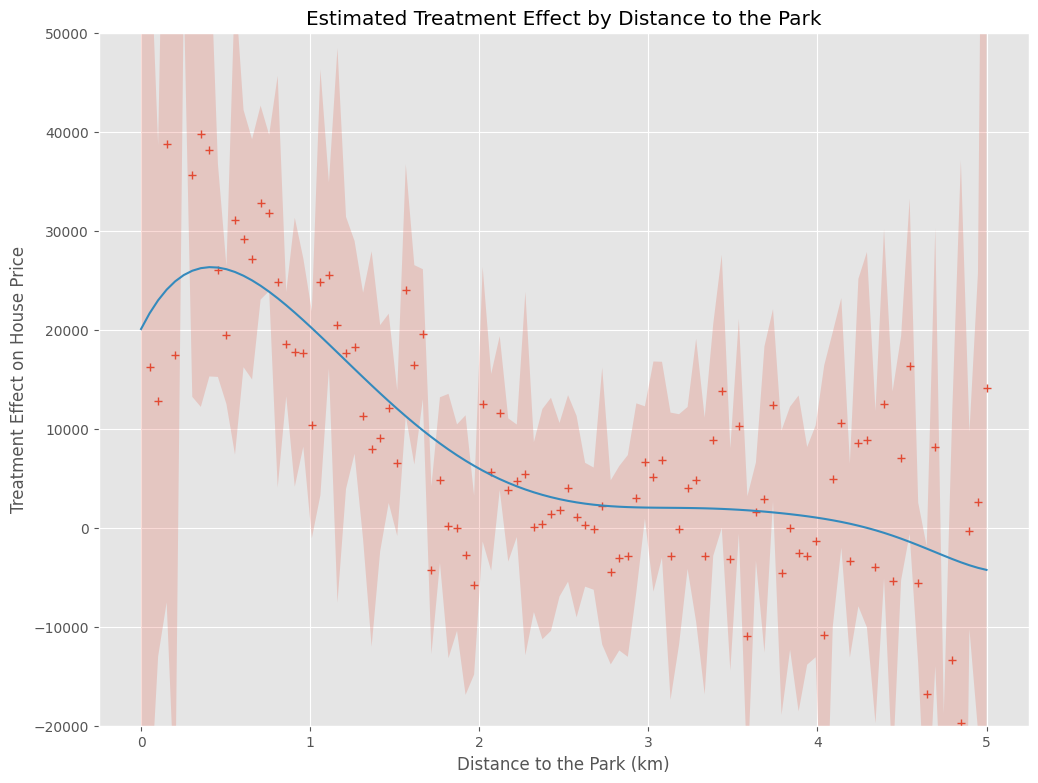

In [8]:
# 結果のプロット

# カーネル回帰でE[Y|X]を算出
kr = KernelReg(treatment_effects,X_test,'c',bw=[0.5])
y_pred, _ = kr.fit(X_test)

# グラフ化
plt.plot(X_test, treatment_effects,'+')
plt.fill_between(X_test.ravel(), treatment_confs[0], treatment_confs[1], alpha=0.2)
plt.plot(X_test, y_pred)
plt.ylim(-20000,50000)
plt.xlabel("Distance to the Park (km)")
plt.ylabel("Treatment Effect on House Price")
plt.title("Estimated Treatment Effect by Distance to the Park")
plt.grid(True)
plt.show()

# ＋が因果効果の推定結果（点推定）、薄い赤の部分が信頼区間（区間推定）、青い実線が因果効果の推定結果を平滑化したもの（傾向線）です。
# 信頼区間の幅が、結構大きなことが分かります。

    カーネル回帰の設定:
    ・kr = KernelReg(treatment_effects,X_test,'c',bw=[0.5]): カーネル回帰モデルを設定します。
    ここで、treatment_effectsは従属変数、X_testは独立変数となります。'c'は連続変数を意味し、bw=[0.5]はバンド幅を0.5として設定しています。

    カーネル回帰による平滑化の実施:
    ・y_pred, _ = kr.fit(X_test): カーネル回帰モデルを用いてX_testの値に基づく平滑化された因果効果を計算します。

    グラフのプロット:
    ・plt.plot(X_test, treatment_effects,'+'): X_testに対する因果効果treatment_effectsをプロットします。各点は+マークで表示されます。
    ・plt.fill_between(X_test.ravel(), treatment_confs[0], treatment_confs[1], alpha=0.2): 信頼区間を塗りつぶしでプロットします。alpha=0.2は透明度を指定しています。
    ・plt.plot(X_test, y_pred): 平滑化された因果効果y_predをプロットします。
    ・その他のplt関数は、グラフの各種設定やラベル、タイトルの追加を行っています。
    ・plt.show(): 上記の設定に基づき、グラフを表示します。


## 一度にハイパーパラメータをチューニングする
    以下のハイパーパラメータを一度にチューニングします。
    ・因果フォレストそのものののハイパーパラメータ
    ・アウトカムモデルのハイパーパラメータ
    ・トリートメントモデルのハイパーパラメータ

    ただし、非常に時間がかかることが予想されます。

    先ず、以下の2つのハイパーパラメータの探索範囲などを設定します。
    ・トリートメントモデルのハイパーパラメータ
    ・アウトカムモデルのハイパーパラメータ
    
    以下、コードです。

In [9]:
# ハイパーパラメータの探索範囲の設定
params={
    'max_depth': [3, 5, 10, None],
    'n_estimators': [10, 30, 50, 100, 200],
    'max_features': [1,2,3]
}
# アウトカムモデル
GS_model_y = lambda: GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=params,
    cv=10,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# トリートメントモデル
GS_model_t = lambda: GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params,
    cv=10,
    n_jobs=-1,
    scoring='f1'
)

    チューニングしたいハイパーパラメータとその探索範囲を指定（params）
    ・max_depth: 決定木の最大深度。Noneは最大深度なしを意味します。
    ・n_estimators: ランダムフォレストにおける決定木の数。
    ・max_features: 最適な分割を探す際に考慮する特徴量の数。

    アウトカムモデル（GS_model_y）
    ・estimator=RandomForestRegressor(): アウトカム（応答変数）に関するモデルとしてランダムフォレスト回帰を使用しています。
    ・param_grid=params: 上で設定したparamsをハイパーパラメータの探索範囲として使用しています。
    ・cv=10: 10-fold交差検証を使用しています。
    ・n_jobs=-1: 使用可能なすべてのCPUコアを使用して並列計算を行います。
    ・scoring='neg_mean_squared_error': ネガティブ平均二乗誤差（Negative Mean Squared Error）をスコアとして使用しています。

    トリートメントモデル（GS_model_t）
    ・estimator=RandomForestClassifier(): トリートメント（処置変数）に関するモデルとしてランダムフォレスト分類を使用しています。
    ・param_grid=params: 上で設定したparamsをハイパーパラメータの探索範囲として使用しています。
    ・cv=10: 10-fold交差検証を使用しています。
    ・n_jobs=-1: 使用可能なすべてのCPUコアを使用して並列計算を行います。
    ・scoring='f1': F1スコアを用いてモデルの性能を評価しています。
    
    GS_model_yとGS_model_tはラムダ関数として定義しています。これらを呼び出すと新しいGridSearchCVインスタンスが都度生成されます。


    次に、残りの因果フォレストそのものののハイパーパラメータを設定し、先程のハイパーパラメータも含めチューニングを実施します。

    以下、コードです。

In [10]:
# 因果フォレストのハイパーパラメータの探索範囲の設定
param_grid = {
    'model_y':[GS_model_y()],
    'model_t':[GS_model_t()],
    'discrete_treatment':[True],
    'n_estimators': [16, 48, 100],
    'min_samples_leaf': [5, 10],
    'max_depth': [3, 5, None],
}

# ハイパーパラメータチューニングの実施
best_model, best_params, best_score = cs_grid_search(
    Y.values,
    T.values,
    X.values,
    W.values,
    CausalForestDML,
    param_grid,
    cv=10
)

# 最適モデルの設定
model = best_model

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
Could not generate out-of-bag predictions on some training data. Consider increasing the number of trees. `ate_` results will take the average of the subset of training data for which out-of-bag predictions where available.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
Could not generate out-of-bag predictions on some training data. Consider increasing the number of trees. `ate_` results will take the average of the subset of training data for which out-of-bag predictions where available.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
Could not generate out-of-bag predictions on some training data. Consider incr

KeyboardInterrupt: 

    因果フォレストのハイパーパラメータの探索範囲の設定（param_grid）
    ・model_y: アウトカム（応答変数）モデルとして先程設定したGS_model_y（グリッドサーチ付きランダムフォレスト回帰）を使用。
    ・model_t: トリートメント（処置変数）モデルとして先程設定したGS_model_t（グリッドサーチ付きランダムフォレスト分類）を使用。
    ・discrete_treatment: 処置が離散値（TrueまたはFalse）であるかどうか。
    ・n_estimators, min_samples_leaf, max_depth: 因果フォレストモデル自体のハイパーパラメータ。

    ハイパーパラメータチューニングの実施
    ・cs_grid_search: この関数はコードに直接は含まれていませんが、おそらくカスタムのグリッドサーチ関数でしょう。この関数は以下のような引数を取ると思われます。
    ・Y,T,X,W: アウトカム、トリートメント、共変量、コントロール変数。
    ・CausalForestDML: 使用する因果推論モデル。
    ・param_grid: 探索するハイパーパラメータの範囲。
    ・cv=10: 10-fold交差検証を使用。
    ・best_model, best_params, best_score: cs_grid_search関数から返される最適なモデル、ハイパーパラメータ、スコア。

    最適モデルの設定
    ・model = best_model: 最適なモデルをmodelとして保存。

    共変量Xの特定の値の因果効果であるCATE（Conditional Average Treatment Effect）を推定します。

    以下、コードです。

In [ ]:
# 結果のプロット

# カーネル回帰でE[Y|X]を算出
kr = KernelReg(treatment_effects,X_test,'c',bw=[0.5])
y_pred, _ = kr.fit(X_test)

# グラフ化
plt.plot(X_test, treatment_effects,'+')
plt.fill_between(X_test.ravel(), treatment_confs[0], treatment_confs[1], alpha=0.2)
plt.plot(X_test, y_pred)
plt.ylim(-20000,50000)
plt.xlabel("Distance to the Park (km)")
plt.ylabel("Treatment Effect on House Price")
plt.title("Estimated Treatment Effect by Distance to the Park")
plt.grid(True)
plt.show()

# ＋が因果効果の推定結果（点推定）、薄い赤の部分が信頼区間（区間推定）、青い実線が因果効果の推定結果を平滑化したもの（傾向線）です。
# 信頼区間の幅が狭くなり、傾向が明確になっていることが分かります。
# しかし、恐ろしく計算の時間がかかります。

## 個別にハイパーパラメータをチューニングする
    先ず、以下のハイパーパラメータを個別にチューニングします。
    ・アウトカムモデルのハイパーパラメータ
    ・トリートメントモデルのハイパーパラメータ

    2つのランダムフォレストで利用するハイパーパラメータの探索範囲を定義します。

    以下、コードです。

In [ ]:
# ハイパーパラメータの探索範囲の設定
params={
    'max_depth': [3, 5, 10, None],
    'n_estimators': [10, 30, 50, 100, 200],
    'max_features': [1,2,3]
}

    アウトカムモデルのハイパーパラメータをチューニングし、チューニングした結果である最適モデルを因果フォレストで利用するアウトカムモデルにします。

    以下、コードです。

In [ ]:
# アウトカムモデルのハイパーパラメータ調整
GS_model_y = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=params,
    cv=10,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

GS_model_y.fit(pd.concat([T,X,W],axis=1),Y)

# 最適モデルをアウトカムモデルとして設定
rfr = RandomForestRegressor()
best_model_y = rfr.set_params(**GS_model_y.best_params_)

    トリートメントモデルのハイパーパラメータをチューニングし、チューニングした結果である最適モデルを因果フォレストで利用するトリートメントモデルにします。

    以下、コードです。

In [ ]:
# トリートメントモデルのハイパーパラメータ調整
GS_model_t = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params,
    cv=10,
    n_jobs=-1,
    scoring='f1'
)

GS_model_t.fit(pd.concat([X,W],axis=1),T)

# 最適モデルをトリートメントモデルとして設定
rfc = RandomForestClassifier()
best_model_t = rfc.set_params(**GS_model_t.best_params_)

    次に、今チューニングして得たアウトカムモデルとトリートメントモデルを因果フォレストに設定し、因果フォレストそのものののハイパーパラメータのチューニングを実施します。

    以下、コードです。

In [ ]:
# 因果フォレストのハイパーパラメータの探索範囲の設定
param_grid = {
    'model_y':[best_model_y],
    'model_t':[best_model_t],
    'discrete_treatment':[True],
    'n_estimators': [16, 48, 100],
    'min_samples_leaf': [5, 10],
    'max_depth': [3, 5, None],
}

# ハイパーパラメータチューニングの実施
best_model, best_params, best_score = cs_grid_search(
    Y.values,
    T.values,
    X.values,
    W.values,
    CausalForestDML,
    param_grid,
    cv=10
)

# 最適モデルの設定
model = best_model

    共変量Xの特定の値の因果効果であるCATE（Conditional Average Treatment Effect）を推定します。

    以下、コードです。

In [ ]:
# 距離ごとの因果効果の推定
X_test = np.linspace(0, 5, 100).reshape(-1, 1)
treatment_effects = model.effect(X_test)
treatment_confs = model.effect_interval(X_test, T0=0, T1=1, alpha=0.05)

    結果をプロットします。推定した因果効果とその信頼区間を表示しています。さらに、推定した因果効果をカーネル回帰を使用して平滑化しています。

    以下、コードです。

In [ ]:
# 結果のプロット

# カーネル回帰でE[Y|X]を算出
kr = KernelReg(treatment_effects,X_test,'c',bw=[0.5])
y_pred, _ = kr.fit(X_test)

# グラフ化
plt.plot(X_test, treatment_effects,'+')
plt.fill_between(X_test.ravel(), treatment_confs[0], treatment_confs[1], alpha=0.2)
plt.plot(X_test, y_pred)
plt.ylim(-20000,50000)
plt.xlabel("Distance to the Park (km)")
plt.ylabel("Treatment Effect on House Price")
plt.title("Estimated Treatment Effect by Distance to the Park")
plt.grid(True)
plt.show()

# ＋が因果効果の推定結果（点推定）、薄い赤の部分が信頼区間（区間推定）、青い実線が因果効果の推定結果を平滑化したもの（傾向線）です。
# 「一度にハイパーパラメータチューニング」とは、ほぼ似たような感じかと思います。
# そして何より、一度にハイパーパラメータをチューニングするより、計算時間が短くなっています。

## 事例２
    事例説明
    ・業種: 製薬業
    ・課題: 新しい薬の治療効果を評価したい。
    ・推論したい因果: 新しい薬の摂取が患者の健康スコアに与える影響。

    Y,T,X,W
    ・Y: 患者の健康スコア（数値、高いほど健康状態が良い）
    ・T: 新しい薬の摂取（1 = 新しい薬を摂取, 0 = プラセボを摂取）
    ・X: 患者の年齢
    ・W: 患者の性別、基礎疾患の有無、治療開始前の健康スコア

    新しい薬の摂取が患者の健康スコアに与える影響を、患者の年齢に応じて評価しています。

# データセットの読み込みと設定
    では、データセットを読み込みます。

    以下、コードです。

In [ ]:
# データセットのロード
df = pd.read_csv("https://www.salesanalytics.co.jp/xnlp")

display(df) #確認

    ・Health_Score: 個人の健康スコアを示す数値です。Yです。
    ・Treatment: 処置（おそらくある種の治療や介入）の有無を示すバイナリ変数です（0 = 受けていない, 1 = 受けている）。Tです。
    ・Age: 個人の年齢を示す数値です。Xです。
    ・Gender: 個人の性別を示すバイナリ変数です（0 = 男性, 1 = 女性）。Wです。
    ・Underlying_Disease: 基礎疾患の有無を示すバイナリ変数です（0 = なし, 1 = あり）。Wです。
    ・Pre-treatment_Health_Score: 処置または治療前の健康スコアを示す数値です。Wです。

    Y,T,X,Wを設定していきます。

    以下、コードです。

In [ ]:
# 変数設定
Y_col = "Health_Score"
T_col = "Treatment"
X_list = ["Age"]
W_list = ["Gender","Underlying_Disease","Pre-treatment_Health_Score"]

# データ設定
Y = df[Y_col]
T = df[T_col]
X = df[X_list]
W = df[W_list]

## ハイパーパラメータをチューニングしない
    因果フォレストを学習します。

    以下、コードです。

In [ ]:
# CausalForestDMLのインスタンスを作成
model = CausalForestDML(
    model_y=RandomForestRegressor(),
    model_t=RandomForestClassifier(),
    discrete_treatment=True
)
# 学習
model.fit(Y, T, X=X, W=W)

    共変量Xの特定の値の因果効果であるCATE（Conditional Average Treatment Effect）を推定します。

    以下、コードです。

In [ ]:
# 年齢ごとの因果効果の推定
X_test = np.linspace(20, 80, 100).reshape(-1, 1)
treatment_effects = model.effect(X_test)
treatment_confs = model.effect_interval(X_test, T0=0, T1=1, alpha=0.05)

    結果をプロットします。推定した因果効果とその信頼区間を表示しています。さらに、推定した因果効果をカーネル回帰を使用して平滑化しています。

    以下、コードです。

In [ ]:
# 結果のプロット

# カーネル回帰でE[Y|X]を算出
kr = KernelReg(treatment_effects,X_test,'c',bw=[10])
y_pred, _ = kr.fit(X_test)

# グラフ化
plt.plot(X_test, treatment_effects,'+')
plt.fill_between(X_test.ravel(), treatment_confs[0], treatment_confs[1], alpha=0.2)
plt.plot(X_test, y_pred)
plt.ylim(5,25)
plt.xlabel("Age")
plt.ylabel("Treatment Effect on Health Score")
plt.title("Estimated Treatment Effect by Age")
plt.grid(True)
plt.show()

# ＋が因果効果の推定結果（点推定）、薄い赤の部分が信頼区間（区間推定）、青い実線が因果効果の推定結果を平滑化したもの（傾向線）です。
# 信頼区間の幅が、結構大きなことが分かります。

## 一度にハイパーパラメータをチューニングする
    以下のハイパーパラメータを一度にチューニングします。
    ・因果フォレストそのものののハイパーパラメータ
    ・アウトカムモデルのハイパーパラメータ
    ・トリートメントモデルのハイパーパラメータ
    
    先ず、以下の2つのハイパーパラメータの探索範囲などを設定します。
    ・トリートメントモデルのハイパーパラメータ
    ・アウトカムモデルのハイパーパラメータ
    
    以下、コードです。
    



In [ ]:
# ハイパーパラメータの探索範囲の設定
params={
    'max_depth': [3, 5, 10, None],
    'n_estimators': [10, 30, 50, 100, 200],
    'max_features': [1,2,3]
}

# アウトカムモデル
GS_model_y = lambda: GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=params,
    cv=10,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# トリートメントモデル
GS_model_t = lambda: GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params,
    cv=10,
    n_jobs=-1,
    scoring='f1'
)

    次に、残りの因果フォレストそのものののハイパーパラメータを設定し、先程のハイパーパラメータも含めチューニングを実施します。

    以下、コードです。

In [ ]:
# 因果フォレストのハイパーパラメータの探索範囲の設定
param_grid = {
    'model_y':[GS_model_y()],
    'model_t':[GS_model_t()],
    'discrete_treatment':[True],
    'n_estimators': [16, 48, 100],
    'min_samples_leaf': [5, 10],
    'max_depth': [3, 5, None],
}

# ハイパーパラメータチューニングの実施
best_model, best_params, best_score = cs_grid_search(
    Y.values,
    T.values,
    X.values,
    W.values,
    CausalForestDML,
    param_grid,
    cv=10
)

# 最適モデルの設定
model = best_model

    共変量Xの特定の値の因果効果であるCATE（Conditional Average Treatment Effect）を推定します。

    以下、コードです。

In [ ]:
# 年齢ごとの因果効果の推定
X_test = np.linspace(20, 80, 100).reshape(-1, 1)
treatment_effects = model.effect(X_test)
treatment_confs = model.effect_interval(X_test, T0=0, T1=1, alpha=0.05)

    結果をプロットします。推定した因果効果とその信頼区間を表示しています。さらに、推定した因果効果をカーネル回帰を使用して平滑化しています。

    以下、コードです。

In [ ]:
# 結果のプロット

# カーネル回帰でE[Y|X]を算出
kr = KernelReg(treatment_effects,X_test,'c',bw=[5])
y_pred, _ = kr.fit(X_test)

# グラフ化
plt.plot(X_test, treatment_effects,'+')
plt.fill_between(X_test.ravel(), treatment_confs[0], treatment_confs[1], alpha=0.2)
plt.plot(X_test, y_pred)
plt.ylim(5,25)
plt.xlabel("Age")
plt.ylabel("Treatment Effect on Health Score")
plt.title("Estimated Treatment Effect by Age")
plt.grid(True)
plt.show()

# ＋が因果効果の推定結果（点推定）、薄い赤の部分が信頼区間（区間推定）、青い実線が因果効果の推定結果を平滑化したもの（傾向線）です。
# 信頼区間の幅が狭くなり、傾向が明確になっていることが分かります。
# しかし、恐ろしく計算の時間がかかります。

## 個別にハイパーパラメータをチューニングする
    先ず、以下のハイパーパラメータを個別にチューニングします。
    ・アウトカムモデルのハイパーパラメータ
    ・トリートメントモデルのハイパーパラメータ

    2つのランダムフォレストで利用するハイパーパラメータの探索範囲を定義します。

    以下、コードです。

In [ ]:
# ハイパーパラメータの探索範囲の設定
params={
    'max_depth': [3, 5, 10, None],
    'n_estimators': [10, 30, 50, 100, 200],
    'max_features': [1,2,3]
}

    アウトカムモデルのハイパーパラメータをチューニングし、チューニングした結果である最適モデルを因果フォレストで利用するアウトカムモデルにします。

    以下、コードです。

In [ ]:
# アウトカムモデルのハイパーパラメータ調整
GS_model_y = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=params,
    cv=10,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

GS_model_y.fit(pd.concat([T,X,W],axis=1),Y)

# 最適モデルをアウトカムモデルとして設定
rfr = RandomForestRegressor()
best_model_y = rfr.set_params(**GS_model_y.best_params_)

    トリートメントモデルのハイパーパラメータをチューニングし、チューニングした結果である最適モデルを因果フォレストで利用するトリートメントモデルにします。

In [ ]:
# トリートメントモデルのハイパーパラメータ調整
GS_model_t = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params,
    cv=10,
    n_jobs=-1,
    scoring='f1'
)

GS_model_t.fit(pd.concat([X,W],axis=1),T)

# 最適モデルをトリートメントモデルとして設定
rfc = RandomForestClassifier()
best_model_t = rfc.set_params(**GS_model_t.best_params_)

    次に、今チューニングして得たアウトカムモデルとトリートメントモデルを因果フォレストに設定し、因果フォレストそのものののハイパーパラメータのチューニングを実施します。

    以下、コードです。

In [ ]:
# 因果フォレストのハイパーパラメータの探索範囲の設定
param_grid = {
    'model_y':[best_model_y],
    'model_t':[best_model_t],
    'discrete_treatment':[True],
    'n_estimators': [16, 48, 100],
    'min_samples_leaf': [5, 10],
    'max_depth': [3, 5, None],
}

# ハイパーパラメータチューニングの実施
best_model, best_params, best_score = cs_grid_search(
    Y.values,
    T.values,
    X.values,
    W.values,
    CausalForestDML,
    param_grid,
    cv=10
)

# 最適モデルの設定
model = best_model

    共変量Xの特定の値の因果効果であるCATE（Conditional Average Treatment Effect）を推定します。

    以下、コードです。

In [ ]:
# 年齢ごとの因果効果の推定
X_test = np.linspace(20, 80, 100).reshape(-1, 1)
treatment_effects = model.effect(X_test)
treatment_confs = model.effect_interval(X_test, T0=0, T1=1, alpha=0.05)

    結果をプロットします。推定した因果効果とその信頼区間を表示しています。さらに、推定した因果効果をカーネル回帰を使用して平滑化しています。

    以下、コードです。

In [ ]:
# 結果のプロット

# カーネル回帰でE[Y|X]を算出
kr = KernelReg(treatment_effects,X_test,'c',bw=[5])
y_pred, _ = kr.fit(X_test)

# グラフ化
plt.plot(X_test, treatment_effects,'+')
plt.fill_between(X_test.ravel(), treatment_confs[0], treatment_confs[1], alpha=0.2)
plt.plot(X_test, y_pred)
plt.ylim(5,25)
plt.xlabel("Age")
plt.ylabel("Treatment Effect on Health Score")
plt.title("Estimated Treatment Effect by Age")
plt.grid(True)
plt.show()

# ＋が因果効果の推定結果（点推定）、薄い赤の部分が信頼区間（区間推定）、青い実線が因果効果の推定結果を平滑化したもの（傾向線）です。
# 一度にハイパーパラメータチューニング」とは、ほぼ似たような感じかと思います。
# そして何より、一度にハイパーパラメータをチューニングするより、計算時間が短くなっています。

## まとめ
    今回は、トリートメントモデルとアウトカムモデルのハイパーパラメータのチューニングも組み込んだ、因果フォレスト全体のハイパーパラメータをチューニングし最適化する方法について説明しました。

    ハイパーパラメータをチューニングし最適化するかどうかで、かなり変わることが分かったかと思います。

    そして、一度にチューニングすると恐ろしく時間が掛るため、お勧めは個別にチューニングする方略です。理由は、どれほど結果が変わらないのに計算結果がでてくるまでのスピードが早いからです。

    最後に、因果フォレスト自体、複雑な状況での因果推論ができますので、興味のなる方は色々と実データで試して見てください。

    次回は、トリートメントモデルとアウトカムモデルで利用するアルゴリズム（数理モデル）を自動選択する方法について言及します。